## Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv
/kaggle/input/hongkongrainfall/hongkong.csv


In [2]:
# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder

# Model evaluation & validation
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

# Machine learning models & optimization
import lightgbm as lgb
import optuna

# Deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Additional ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from catboost import CatBoostClassifier

## Load data

In [3]:
# Load competition data
# - Training dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv').set_index('id')

# - Testing dataset
test_data = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv').set_index('id')

# Load original data (Hong Kong rainfall dataset)
original = pd.read_csv("/kaggle/input/hongkongrainfall/hongkong.csv", encoding='latin-1')

# Load submission template
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')

## EDA Strategy:
1. First, look briefly at original data to get more insights about the competition data
2. Second, look closely at competition data (train data)

## Variable Descriptions:
* **Day**: Sequential identifier for observations
* **Pressure**: Atmospheric pressure measurement (unit: hPa)
* **Maxtemp**: Daily maximum temperature (unit: °C)
* **Temperature**: Daily average temperature (unit: °C)
* **Mintemp**: Daily minimum temperature (unit: °C)
* **Dewpoint**: Dew point temperature (unit: °C)
   * Temperature at which water vapor in the air condenses into dew
   * Closely related to humidity - smaller difference between temperature and dewpoint indicates higher humidity
   * Important indicator for rainfall prediction
* **Humidity**: Relative humidity ratio
* **Cloud**: Cloud coverage ratio
* **Sunshine**: Hours of sunshine
* **Winddirection**: Wind direction (unit: degrees)
* **Windspeed**: Wind speed (unit: km/h)
* **Rainfall**: Target variable - indicates rainfall occurrence (1) or non-occurrence (0)

In [4]:
# Print basic dataset information
print("\nData shape (rows, columns):")
print(original.shape)

# Display column names
print("\nColumn information:")
print(original.columns)

# Preview first 5 rows
print("\nFirst 5 rows of data:")
print(original.head())

# Summary statistics for numerical columns
print("\nStatistical information:")
print(original.describe())

# Check data types for each column
print("\nData type information:")
print(original.dtypes)

# Check for missing values in each column
print("\nMissing value check:")
print(original.isnull().sum())


Data shape (rows, columns):
(3591, 17)

Column information:
Index(['year', 'month', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'rainfall', 'low visibility hour',
       'sunshine', 'radiation', 'evaporation', 'winddirection', 'windspeed'],
      dtype='object')

First 5 rows of data:
   year  month  day  pressure  maxtemp  temparature  mintemp  dewpoint  \
0  2010      1    1    1018.1     18.1         16.2     15.0      11.4   
1  2010      1    2    1016.1     20.0         17.4     16.1      15.4   
2  2010      1    3    1017.1     18.3         17.0     15.8      14.7   
3  2010      1    4    1015.1     19.9         17.9     15.9      14.6   
4  2010      1    5    1015.6     18.5         17.3     15.9      14.5   

   humidity  cloud rainfall  low visibility hour sunshine radiation  \
0        73     84     Î¢Á¿                 17.0      2.7      9.86   
1        88     88      5.2                  3.0      0.5      6.74   
2  

In [5]:
# Explore rainfall data
print("Rainfall data type:", original['rainfall'].dtype)
print("Unique rainfall values:", original['rainfall'].unique())
print("Rainfall value distribution:\n", original['rainfall'].value_counts())

Rainfall data type: object
Unique rainfall values: ['Î¢Á¿' '5.2' '3.5' '-' '0.8' '1.2' '0.5' '0.9' '12.5' '0.4' '94.1' '7.1'
 '1.7' '2.3' '0.6' '1' '3.7' '0.1' '0.3' '4.9' '2.7' '8.9' '2' '1.8' '9.6'
 '8.2' '3.1' '1.1' '6.8' '0.2' '40.6' '29.1' '3.9' '27.6' '0.7' '11.9'
 '55.7' '8.1' '10.1' '22.6' '5.3' '16.1' '29.3' '16.7' '58.4' '29' '6.4'
 '3.8' '1.9' '1.4' '4.6' '41' '39' '2.9' '127.6' '44.2' '43.2' '8.4'
 '17.8' '40' '29.6' '182.4' '14.6' '33.6' '122.5' '5.1' '41.6' '1.6'
 '39.1' '18' '22.2' '3' '8.7' '13.5' '3.2' '56.4' '22.1' '9.1' '23.7'
 '42.6' '30.1' '16.2' '47.4' '22.5' '58.8' '51.8' '95.9' '67' '178.8'
 '4.4' '2.2' '10.2' '24.3' '14.7' '12.9' '4.2' '17' '2.4' '11.1' '26.7'
 '6.3' '33.5' '14.5' '7.5' '42.8' '69.8' '9.3' '2.8' '11.6' '28.4' '5.9'
 '75.2' '77.5' '8.3' '41.4' '106.6' '76.5' '11.2' '33.2' '10.9' '21.8'
 '12.4' '34.9' '60.5' '4.3' '5.6' '15.2' '9.9' '17.9' '8.5' '13.7' '2.6'
 '20.4' '2.5' '30.8' '12.7' '3.3' '6.9' '105.8' '30.7' '1.5' '13.9' '18.1'
 '8.6' '19.1' 

### Discrepancies Between Original Data and Competition Data

#### 1. Data Source
* Competition data combines portions of Hong Kong weather data from 2015 and 2016
* Not complete annual data, but a mix of January-July 2016 and August-December 2015

#### 2. Variable Structure Differences
* Original data: Contains additional variables such as 'year', 'month', 'low visibility hour', 'radiation', 'evaporation'
* Competition data: Selectively uses only a subset of variables

#### 3. Missing Value Inconsistencies
* Original data: Missing values in 'low visibility hour'(1), 'evaporation'(3), 'windspeed'(1)
* Competition data: One missing value in 'winddirection' in the test set

#### 4. Data Quality Issues
* According to forum discussions, 'winddirection' and 'windspeed' values don't match the original
* Original 'rainfall' variable has diverse values: (no rain), `微量`(trace amounts), numeric values (0.1~52.1)
* Analysis of original data: '-' (1351 instances of no rain), `微量`/`Î¢Á¿` (770 instances for trace amounts), and numeric values ranging from 0.1 to 52.1 (total of 439 instances with measurable rainfall)
* In the competition, all rainfall information is binarized to simply 0 (no rain) and 1 (rain)

In [6]:
# Explore competition training data
print("\nData shape (rows, columns):")
print(train_data.shape)

# Display column names
print("\nColumn information:")
print(train_data.columns)

# Preview first 5 rows
print("\nFirst 5 rows of data:")
print(train_data.head())

# Summary statistics for numerical columns
print("\nStatistical information:")
print(train_data.describe())

# Check data types for each column
print("\nData type information:")
print(train_data.dtypes)

# Check for missing values in each column
print("\nMissing value check:")
print(train_data.isnull().sum())


Data shape (rows, columns):
(2190, 12)

Column information:
Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall'],
      dtype='object')

First 5 rows of data:
    day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
id                                                                            
0     1    1017.4     21.2         20.6     19.9      19.4      87.0   88.0   
1     2    1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
2     3    1024.1     19.4         16.1     14.6       9.3      75.0   47.0   
3     4    1013.4     18.1         17.8     16.9      16.8      95.0   95.0   
4     5    1021.8     21.3         18.4     15.2       9.6      52.0   45.0   

    sunshine  winddirection  windspeed  rainfall  
id                                                
0        1.1           60.0       17.2         1  
1        0.0          

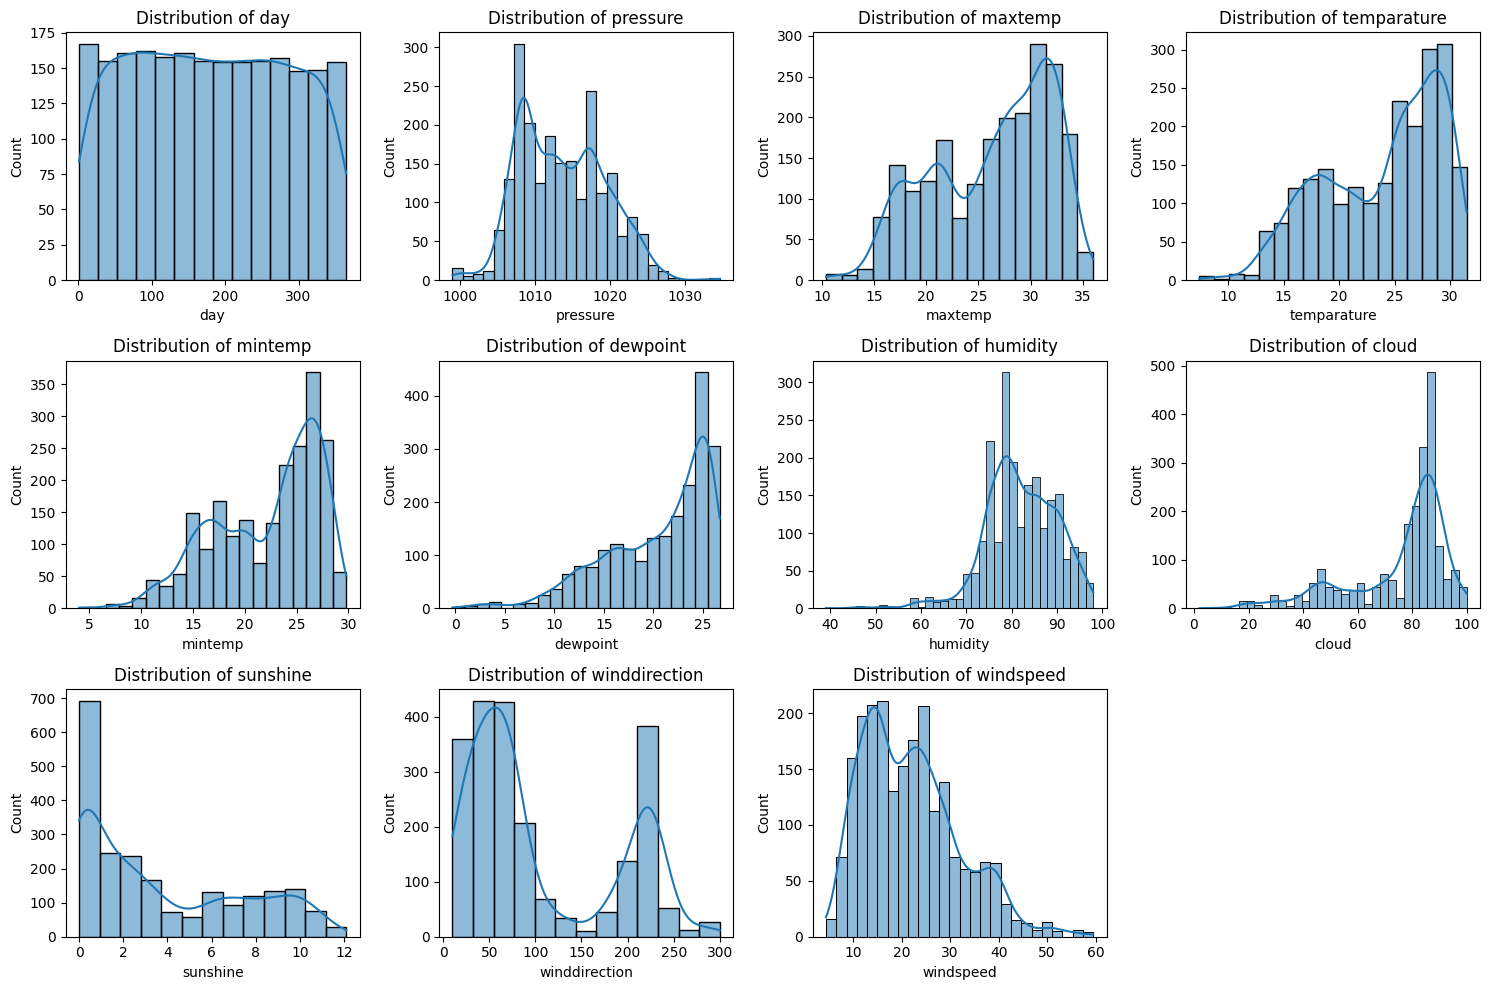

In [7]:
# Set graph size
plt.figure(figsize=(15, 10))

# Select numerical columns
numeric_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

# Create histograms
for i, column in enumerate(numeric_columns):
    if column != 'id' and column != 'rainfall':  # Exclude target variable and ID
        plt.subplot(3, 4, i + 1)
        sns.histplot(train_data[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.tight_layout()

plt.show()

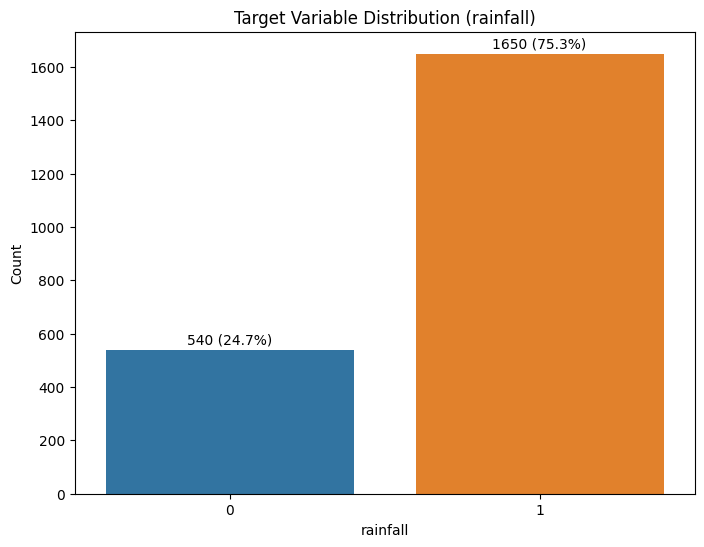

In [8]:
# Visualize target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='rainfall', data=train_data)
plt.title('Target Variable Distribution (rainfall)')
plt.ylabel('Count')

rain_counts = [train_data['rainfall'].value_counts()[0], train_data['rainfall'].value_counts()[1]]

for i, count in enumerate(rain_counts):
    plt.text(i, count + 10, f'{count} ({count/len(train_data):.1%})', 
             ha='center', va='bottom')
plt.show()

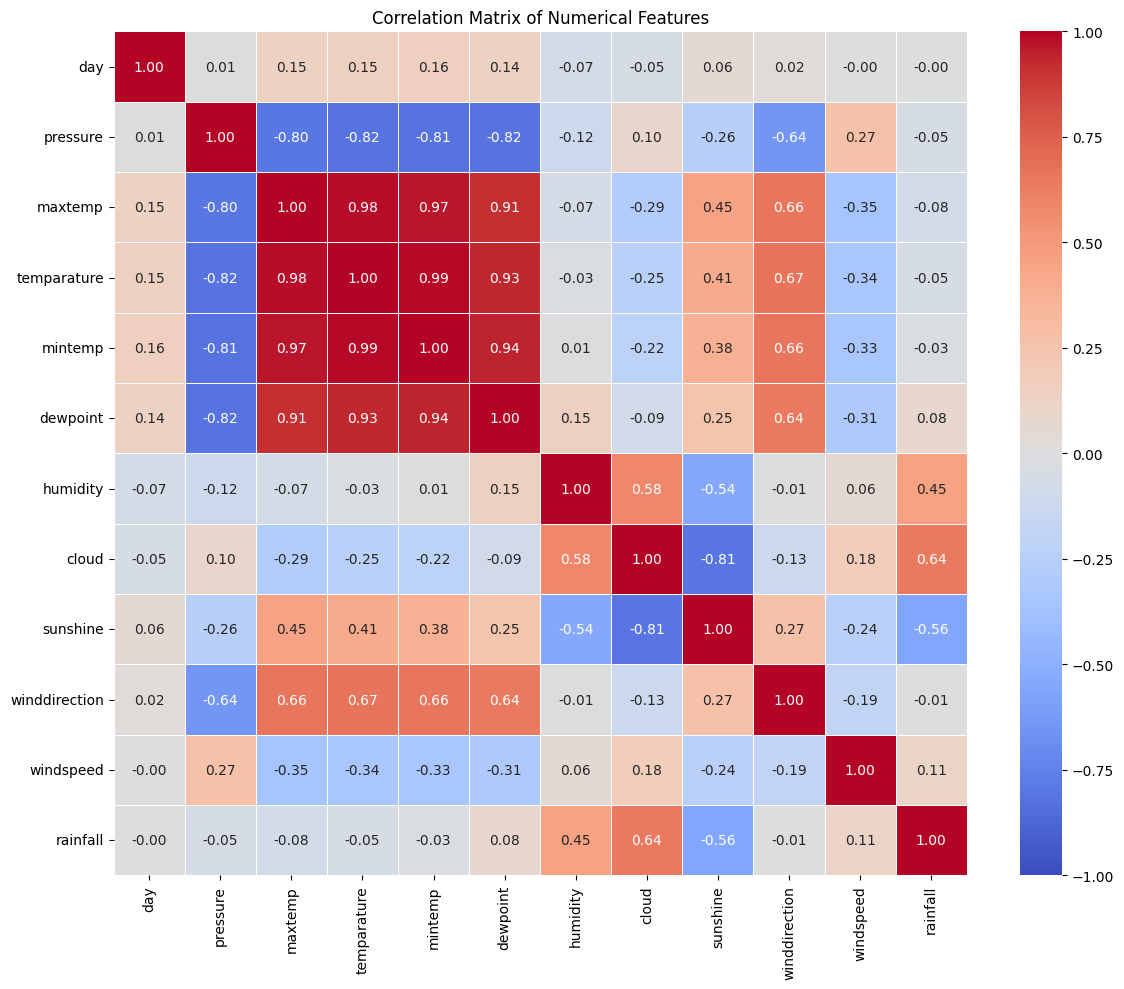

Features correlation with target (rainfall):
rainfall         1.000000
cloud            0.641191
humidity         0.454213
windspeed        0.111625
dewpoint         0.081965
day             -0.000462
winddirection   -0.006939
mintemp         -0.026841
temparature     -0.049660
pressure        -0.049886
maxtemp         -0.079304
sunshine        -0.555287
Name: rainfall, dtype: float64


In [9]:
# Check correlation between numerical variables
plt.figure(figsize=(12, 10))
corr = train_data.select_dtypes(include=['int64', 'float64']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Print correlation with target variable
target_corr = corr['rainfall'].sort_values(ascending=False)
print("Features correlation with target (rainfall):")
print(target_corr)

## Key Correlation Insights:

### Relationships with Target Variable (Rainfall):
* **Cloud (0.64)**: Cloud coverage is the strongest indicator for rainfall prediction
* **Sunshine (-0.56)**: Decreased sunshine hours indicates increased rainfall probability
* **Humidity (0.45)**: Higher humidity is associated with higher rainfall probability

### Multicollinearity Issues:
* Temperature, Maxtemp, and Mintemp contain almost identical information (correlation coefficients 0.97-0.99)
* Dewpoint also has high correlation with temperature variables (0.91-0.94)
* Cloud and Sunshine have strong negative correlation (-0.81)

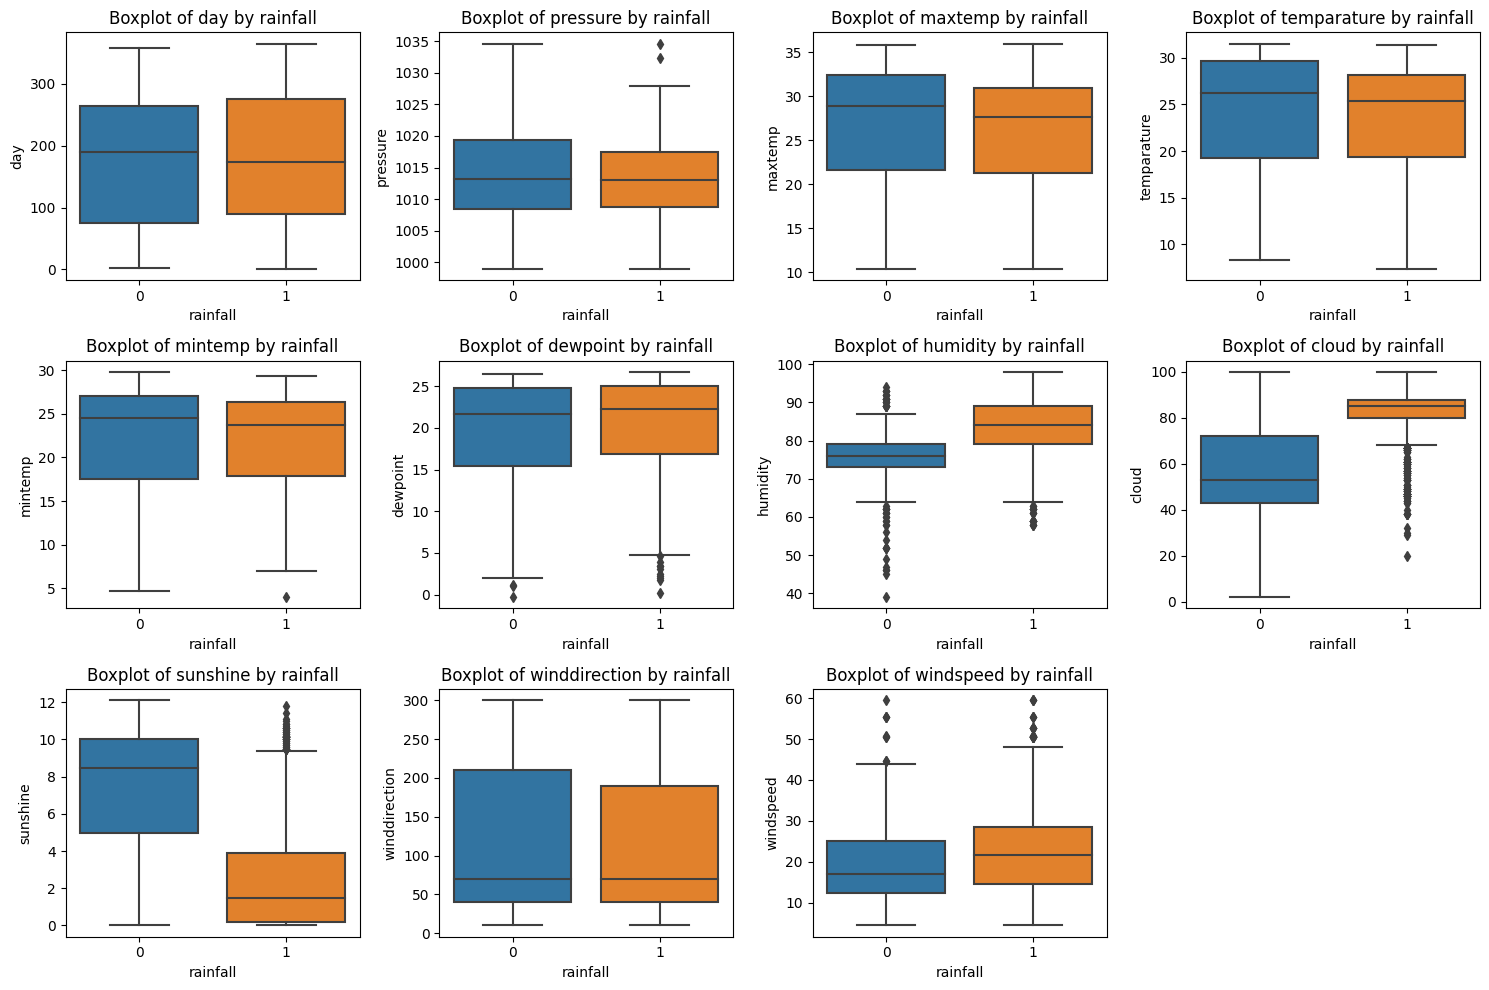

In [10]:
# Outlier detection
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns):
    if column != 'id' and column != 'rainfall':  # Exclude target variable and ID
        plt.subplot(3, 4, i + 1)
        sns.boxplot(x='rainfall', y=column, data=train_data)
        plt.title(f'Boxplot of {column} by rainfall')
        plt.tight_layout()
plt.show()

Data type of 'day': int64


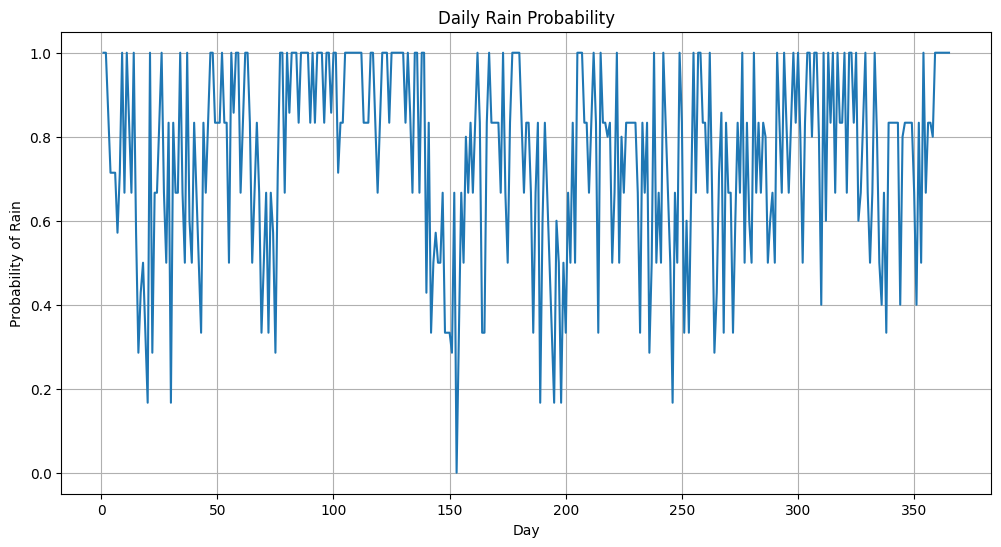

<Figure size 1200x600 with 0 Axes>

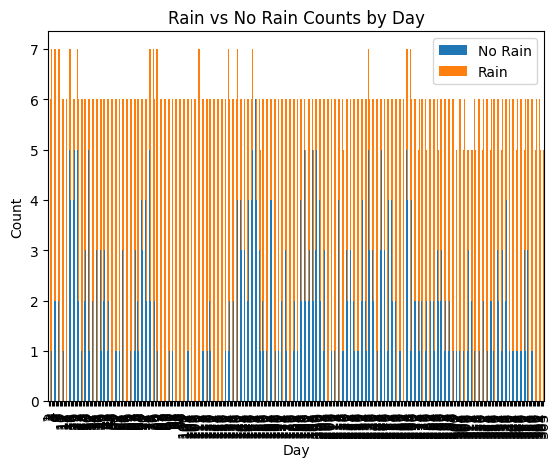

In [11]:
# Temporal Pattern Analysis using the 'day' variable
if 'day' in train_data.columns:
    # Check the data type of 'day'
    print(f"Data type of 'day': {train_data['day'].dtype}")
    
    # If 'day' is not already in datetime format, convert it if possible
    # (Skip this if 'day' is just a number without actual date meaning)
    
    # Analyze rainfall probability by day
    plt.figure(figsize=(12, 6))
    daily_rain_prob = train_data.groupby('day')['rainfall'].mean()
    daily_rain_prob.plot(kind='line')
    plt.title('Daily Rain Probability')
    plt.xlabel('Day')
    plt.ylabel('Probability of Rain')
    plt.grid(True)
    plt.show()
    
    # Count of rainy days vs non-rainy days by day
    plt.figure(figsize=(12, 6))
    rain_counts_by_day = pd.crosstab(train_data['day'], train_data['rainfall'])
    rain_counts_by_day.plot(kind='bar', stacked=True)
    plt.title('Rain vs No Rain Counts by Day')
    plt.xlabel('Day')
    plt.ylabel('Count')
    plt.legend(['No Rain', 'Rain'])
    plt.show()

### Key Observations:
* All data is numeric and mostly shows sinusoidal patterns
   * e.g. The probability of rain exhibits periodic patterns that rise and fall according to seasons. Time series patterns and seasonality should be reflected in the model.

## Baseline model

In [12]:
# Select features and target variable
x = train_data.drop(['rainfall'], axis=1)
y = train_data['rainfall']
x_test = test_data.copy()

In [13]:
# Print columns with NaN values
print(x_test.isna().sum())

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


### Handling Missing Value in 'winddirection' Column

#### Implemented Approach: Mode Imputation

In [14]:
# Fill NaN values in 'winddirection' column with the mode (most frequent value)
x_test['winddirection'].fillna(x['winddirection'].mode()[0], inplace=True)

#### Pros and Cons of Mode Imputation

**Pros**:
* Simple to implement and easy to understand
* Low computational cost
* Effective for single missing values
* Mode may be more appropriate than median for circular data like wind direction

**Cons**:
* Doesn't provide information about missing patterns to the model
* Doesn't consider multivariate missing patterns
* May introduce bias when there are multiple missing values

#### Alternative Approach: Circular Mean for Directional Data
The commented code below shows an alternative approach that considers the circular nature of wind direction data:

In [15]:
# Alternative: Using circular mean for directional data
# Wind direction is circular data (0-360 degrees) requiring special handling for mean calculation
# import numpy as np
# angles = np.radians(x['winddirection'].dropna())
# mean_sin = np.mean(np.sin(angles))
# mean_cos = np.mean(np.cos(angles))
# mean_angle = np.degrees(np.arctan2(mean_sin, mean_cos)) % 360
# x_test['winddirection'].fillna(mean_angle, inplace=True)

In [16]:
# Split the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

# Create and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train, y_train)

# Get probability predictions for validation set
y_valid_prob = model.predict_proba(x_valid)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_valid, y_valid_prob)
print(f"Validation AUC: {auc:.4f}")

# Make predictions on the test set
y_pred_final = model.predict_proba(x_test)[:, 1]  

"""
# Create submission DataFrame
submission = pd.DataFrame({'id': test_data.index, 'rainfall': y_pred_final})

# Save the predictions as 'submission.csv'
submission.to_csv('submission.csv', index=False)
print("\nSubmission file saved as 'submission.csv'.")
"""

Validation AUC: 0.8726


'\n# Create submission DataFrame\nsubmission = pd.DataFrame({\'id\': test_data.index, \'rainfall\': y_pred_final})\n\n# Save the predictions as \'submission.csv\'\nsubmission.to_csv(\'submission.csv\', index=False)\nprint("\nSubmission file saved as \'submission.csv\'.")\n'

## Comparative Analysis of Advanced ML Models
### Advanced Models:
- Random Forest
- XGBoost
- LightGBM
- CatBoost

In [17]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Get probability predictions for validation set
rf_valid_prob = rf_model.predict_proba(x_valid)[:, 1]

# Calculate AUC
rf_auc = roc_auc_score(y_valid, rf_valid_prob)
print(f"Random Forest Validation AUC: {rf_auc:.4f}")

# Make predictions on the test set
rf_pred_final = rf_model.predict_proba(x_test)[:, 1]

# Create submission DataFrame
rf_submission = pd.DataFrame({'id': test_data.index, 'rainfall': rf_pred_final})

"""
# Create submission DataFrame
rf_submission = pd.DataFrame({'id': test_data.index, 'rainfall': rf_pred_final})

# Save the predictions
rf_submission.to_csv('rf_submission.csv', index=False)
print("Random Forest submission saved as 'rf_submission.csv'")
"""

Random Forest Validation AUC: 0.8573


'\n# Create submission DataFrame\nrf_submission = pd.DataFrame({\'id\': test_data.index, \'rainfall\': rf_pred_final})\n\n# Save the predictions\nrf_submission.to_csv(\'rf_submission.csv\', index=False)\nprint("Random Forest submission saved as \'rf_submission.csv\'")\n'

In [18]:
# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(x_train, y_train)

# Get probability predictions for validation set
xgb_valid_prob = xgb_model.predict_proba(x_valid)[:, 1]

# Calculate AUC
xgb_auc = roc_auc_score(y_valid, xgb_valid_prob)
print(f"XGBoost Validation AUC: {xgb_auc:.4f}")

# Make predictions on the test set
xgb_pred_final = xgb_model.predict_proba(x_test)[:, 1]

"""
# Create submission DataFrame
xgb_submission = pd.DataFrame({'id': test_data.index, 'rainfall': xgb_pred_final})

# Save the predictions
xgb_submission.to_csv('xgb_submission.csv', index=False)
print("XGBoost submission saved as 'xgb_submission.csv'")
"""

XGBoost Validation AUC: 0.8656


'\n# Create submission DataFrame\nxgb_submission = pd.DataFrame({\'id\': test_data.index, \'rainfall\': xgb_pred_final})\n\n# Save the predictions\nxgb_submission.to_csv(\'xgb_submission.csv\', index=False)\nprint("XGBoost submission saved as \'xgb_submission.csv\'")\n'

In [19]:
# Create and train the LightGBM model
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(x_train, y_train)

# Get probability predictions for validation set
lgb_valid_prob = lgb_model.predict_proba(x_valid)[:, 1]

# Calculate AUC
lgb_auc = roc_auc_score(y_valid, lgb_valid_prob)
print(f"LightGBM Validation AUC: {lgb_auc:.4f}")

# Make predictions on the test set
lgb_pred_final = lgb_model.predict_proba(x_test)[:, 1]

"""
# Create submission DataFrame
lgb_submission = pd.DataFrame({'id': test_data.index, 'rainfall': lgb_pred_final})

# Save the predictions
lgb_submission.to_csv('lgb_submission.csv', index=False)
print("LightGBM submission saved as 'lgb_submission.csv'")
"""

[LightGBM] [Info] Number of positive: 1331, number of negative: 421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759703 -> initscore=1.151053
[LightGBM] [Info] Start training from score 1.151053
LightGBM Validation AUC: 0.8566


'\n# Create submission DataFrame\nlgb_submission = pd.DataFrame({\'id\': test_data.index, \'rainfall\': lgb_pred_final})\n\n# Save the predictions\nlgb_submission.to_csv(\'lgb_submission.csv\', index=False)\nprint("LightGBM submission saved as \'lgb_submission.csv\'")\n'

In [20]:
# Create and train the CatBoost model (with verbose=0 to suppress output)
cat_model = CatBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)
cat_model.fit(x_train, y_train)

# Get probability predictions for validation set
cat_valid_prob = cat_model.predict_proba(x_valid)[:, 1]

# Calculate AUC
cat_auc = roc_auc_score(y_valid, cat_valid_prob)
print(f"CatBoost Validation AUC: {cat_auc:.4f}")

# Make predictions on the test set
cat_pred_final = cat_model.predict_proba(x_test)[:, 1]

"""
# Create submission DataFrame
cat_submission = pd.DataFrame({'id': test_data.index, 'rainfall': cat_pred_final})

# Save the predictions
cat_submission.to_csv('cat_submission.csv', index=False)
print("CatBoost submission saved as 'cat_submission.csv'")
"""

CatBoost Validation AUC: 0.8669


'\n# Create submission DataFrame\ncat_submission = pd.DataFrame({\'id\': test_data.index, \'rainfall\': cat_pred_final})\n\n# Save the predictions\ncat_submission.to_csv(\'cat_submission.csv\', index=False)\nprint("CatBoost submission saved as \'cat_submission.csv\'")\n'

# Model Performance Comparison

| Model | Validation AUC |
|-------|----------------|
| Logistic Regression | 0.8726 |
| CatBoost | 0.8669 |
| XGBoost | 0.8656 |
| Random Forest | 0.8573 |
| LightGBM | 0.8566 |

**Conclusion**: Without feature engineering, the basic Logistic Regression model performs best on this dataset.

## Sources
- 🏆 **Kaggle Competition:** [Binary Prediction with a Rainfall Dataset](https://www.kaggle.com/competitions/playground-series-s5e3)
- 💻 **Reference Notebook:** [🌧️PS5E3 | Rainfall Prediction | Classification](https://www.kaggle.com/code/arunklenin/ps5e3-rainfall-prediction-classification/notebook)
- 🔗 **Original data:** [Hong Kong Weather Observation Summary 2010~2019](https://www.kaggle.com/datasets/act18l/hongkongrainfall)
- 🔗 **Discussion:** [Original dataset is Hong Kong data from 2015 and 2016](https://www.kaggle.com/competitions/playground-series-s5e3/discussion/566908)